In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

pd.plotting.register_matplotlib_converters()

## Read the historical temperatures
Historical temperatures for Hanover, NH were downloaded from the [NOAA Global Climatology Network](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn).  The following cell uses Pandas to read the CSV data file and display the first few rows of the dataframe.

In [2]:
filename = '2204856.csv'
df = pd.read_csv(filename, parse_dates=['DATE'])
df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES
0,USC00273850,"HANOVER, NH US",43.7052,-72.2855,178.0,1884-11-01,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00273850,"HANOVER, NH US",43.7052,-72.2855,178.0,1884-11-02,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00273850,"HANOVER, NH US",43.7052,-72.2855,178.0,1884-11-03,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00273850,"HANOVER, NH US",43.7052,-72.2855,178.0,1884-11-04,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00273850,"HANOVER, NH US",43.7052,-72.2855,178.0,1884-11-05,NaN,NaN,NaN,NaN,NaN,NaN


Our dataset contains the recorded maximum and minimum temperatures for each day.  In this example, we are concerned with the maximum temperatures in the first week of July.  The following creates boolean lists that will enable us to extract the data in the first week of July for dates before 2010 and dates after 2010.

In [3]:
keep_old = [(date.year<2010)&(date.month==7)&(date.day<=7) for date in df['DATE']]
keep_new = [(date.year>=2010)&(date.month==7)&(date.day<=7) for date in df['DATE']]

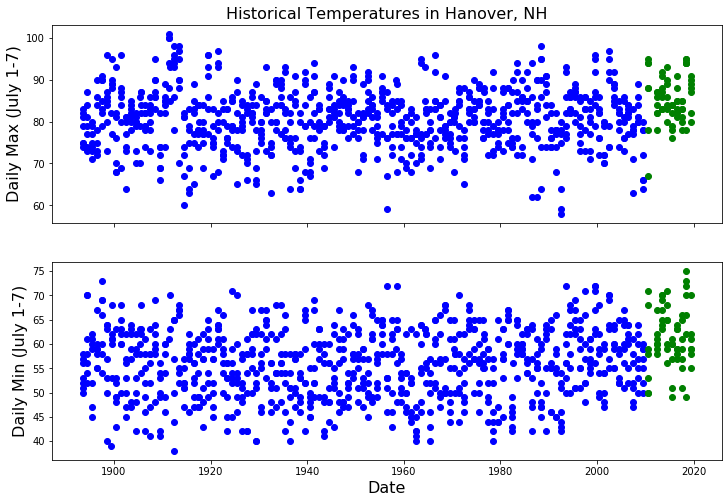

In [4]:
fig,axs = plt.subplots(nrows=2,sharex=True, figsize=(12,8))
axs[0].plot(df['DATE'][keep_old],df['TMAX'][keep_old],'ob')
axs[1].plot(df['DATE'][keep_old],df['TMIN'][keep_old],'ob')
axs[0].plot(df['DATE'][keep_new],df['TMAX'][keep_new],'og')
axs[1].plot(df['DATE'][keep_new],df['TMIN'][keep_new],'og')

axs[0].set_ylabel('Daily Max (July 1-7)',fontsize=16)
axs[1].set_ylabel('Daily Min (July 1-7)',fontsize=16)
axs[1].set_xlabel('Date',fontsize=16)
axs[0].set_title('Historical Temperatures in Hanover, NH', fontsize=16)

plt.savefig('TimeSeries.pdf')
plt.show()

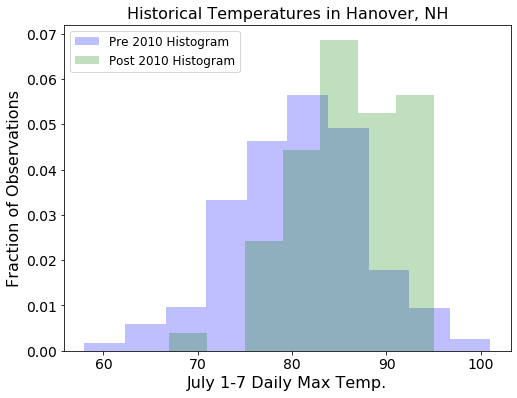

In [5]:
plt.subplots(figsize=(8,6))

tmax_old = df['TMAX'][keep_old].to_numpy().reshape(-1,1)
tmax_old = tmax_old[~np.isnan(tmax_old)] # ignore any nans in the temperatures

tmax_new = df['TMAX'][keep_new].to_numpy().reshape(-1,1)
tmax_new = tmax_new[~np.isnan(tmax_new)] # ignore any nans in the temperatures

h1 = plt.hist(tmax_old,10, color='b', density=True, alpha=0.25, label='Pre 2010 Histogram')
h2 = plt.hist(tmax_new,7, color='g', density=True, alpha=0.25, label='Post 2010 Histogram')

plt.ylabel('Fraction of Observations',fontsize=16)
plt.xlabel('July 1-7 Daily Max Temp.', fontsize=16)
plt.title('Historical Temperatures in Hanover, NH', fontsize=16)

plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('Histogram.pdf')
plt.show()

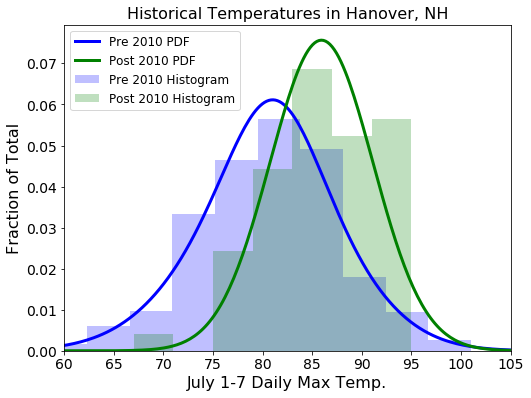

In [6]:
plt.subplots(figsize=(8,6))

old_mix = GaussianMixture(n_components=5,n_init=20,tol=1e-5,max_iter=1000,init_params='random')
old_mix.fit(tmax_old.reshape(-1,1))

new_mix = GaussianMixture(n_components=2,n_init=20,tol=1e-5,max_iter=1000,init_params='random')
new_mix.fit(tmax_new.reshape(-1,1))

plot_temps = np.linspace(20,130,500).reshape(-1,1)

h1 = plt.hist(tmax_old,10, color='b', density=True, alpha=0.25, label='Pre 2010 Histogram')
h2 = plt.hist(tmax_new,7, color='g', density=True, alpha=0.25, label='Post 2010 Histogram')

old_log_vals = old_mix.score_samples(plot_temps)
new_log_vals = new_mix.score_samples(plot_temps)

plt.plot(plot_temps, np.exp(old_log_vals), 'b', linewidth=3, label='Pre 2010 PDF')
plt.plot(plot_temps, np.exp(new_log_vals), 'g', linewidth=3, label='Post 2010 PDF')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([60,105])

plt.ylabel('Fraction of Total',fontsize=16)
plt.xlabel('July 1-7 Daily Max Temp.', fontsize=16)
plt.legend(fontsize=12)
plt.title('Historical Temperatures in Hanover, NH', fontsize=16)

plt.savefig('Density.pdf')

plt.show()

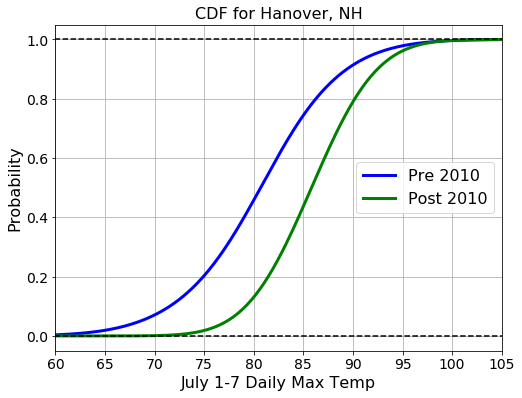

In [7]:
plt.subplots(figsize=(8,6))

# Approximately integrate the PDFs to obtain the CDFs
old_cdf = (plot_temps[1]-plot_temps[0])*np.cumsum(np.exp(old_log_vals))
old_cdf /= old_cdf[-1]
new_cdf = (plot_temps[1]-plot_temps[0])*np.cumsum(np.exp(new_log_vals))
new_cdf /= new_cdf[-1]

plt.plot(plot_temps, old_cdf, '-b', linewidth=3, label='Pre 2010')
plt.plot(plot_temps, new_cdf, '-g', linewidth=3, label='Post 2010')
plt.plot([plot_temps[0],plot_temps[-1]], [0,0], '--k')
plt.plot([plot_temps[0],plot_temps[-1]], [1,1], '--k')

plt.xlim([60,105])
plt.xlabel('July 1-7 Daily Max Temp', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.title('CDF for Hanover, NH', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(which='both')

plt.savefig('Cumulative.pdf')
plt.show()

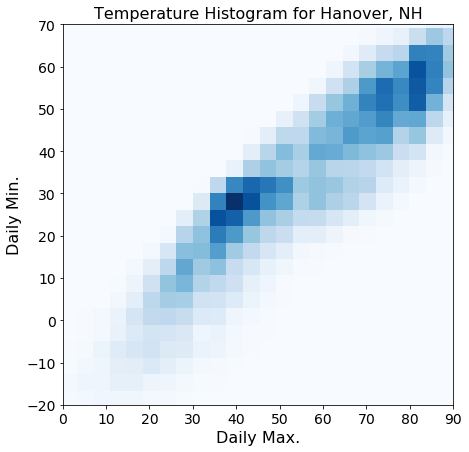

In [8]:
fig, ax = plt.subplots(figsize=(7,7))

nan_inds = np.isnan(df['TMAX']) | np.isnan(df['TMIN'])

joint_temps = df[['TMAX','TMIN']][~nan_inds].to_numpy()

h2d = ax.hist2d(joint_temps[:,0], joint_temps[:,1],30,cmap='Blues')

ax.set_xlabel('Daily Max.', fontsize=16)
ax.set_ylabel('Daily Min.', fontsize=16)
ax.set_title('Temperature Histogram for Hanover, NH', fontsize=16)
ax.set_xlim([0,90])
ax.set_ylim([-20,70])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('JointHistogram.pdf')
plt.show()

In [9]:
joint_mix = GaussianMixture(n_components=4,n_init=20,tol=1e-5,max_iter=1000)#,init_params='random')
joint_mix.fit(joint_temps)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
                means_init=None, n_components=4, n_init=20,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=1e-05, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [10]:
xs = np.linspace(0,100,80)
ys = np.linspace(-20,90,80)
X,Y = np.meshgrid(xs,ys)

eval_pts = np.hstack([X.reshape(-1,1), Y.reshape(-1,1)])
joint_dens = joint_mix.score_samples(eval_pts).reshape(80,80)

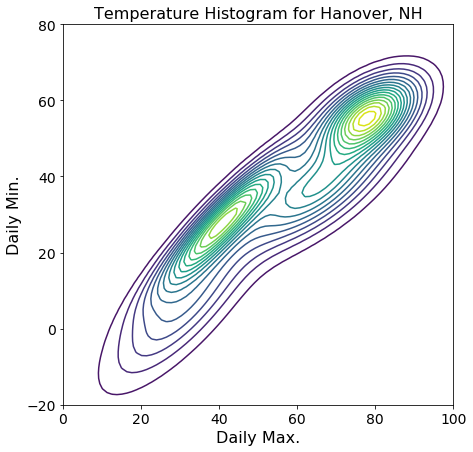

In [11]:
fig, ax = plt.subplots(figsize=(7,7))

ax.contour(X,Y,np.exp(joint_dens),20)

ax.set_xlabel('Daily Max.', fontsize=16)
ax.set_ylabel('Daily Min.', fontsize=16)
ax.set_title('Temperature Histogram for Hanover, NH', fontsize=16)
ax.set_xlim([0,100])
ax.set_ylim([-20,80])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('JointDensity.pdf')
plt.show()


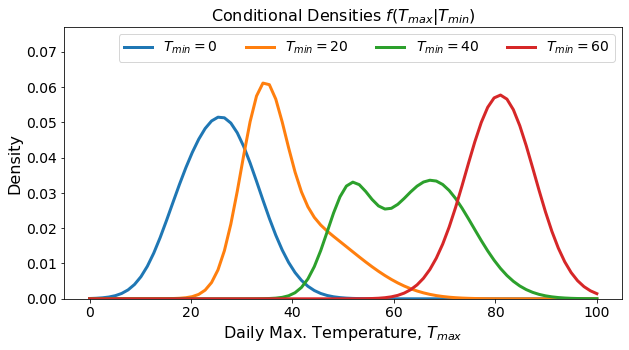

In [30]:
fig, ax = plt.subplots(figsize=(10,5))

min_temps = [0.,20.,40.,60.]

for min_temp in min_temps:
    eval_pts = np.hstack([xs.reshape(-1,1), min_temp*np.ones((80,1))])
    cond_log_dens = joint_mix.score_samples(eval_pts)
    cond_dens = np.exp(cond_log_dens)
    cond_dens /= (xs[1]-xs[0])*np.sum(cond_dens)


    plt.plot(xs,cond_dens,linewidth=3, label='$T_{min}=%d$'%min_temp)
    
plt.xlabel('Daily Max. Temperature, $T_{max}$', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Conditional Densities $f(T_{max} | T_{min})$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ymin,ymax = ax.get_ylim()
ax.set_ylim([0,1.2*ymax])
plt.legend(fontsize=14,ncol=4)

plt.savefig('Conditional.pdf')

plt.show()
